In [1]:
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import pickle5 as pickle
from glob import glob
from datetime import datetime
import re
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu


In [2]:
threshold={'hatespeech':0.9,'fearspeech':0.7,'normal':0.7}
dict_labels={'hatespeech':2,'fearspeech':1,'normal':0}
reverse_dict_labels={dict_labels[key]:key for key in dict_labels.keys()}

In [3]:
import re
import urllib.parse as urlparse
import emoji


GENERIC_TLDS = [
    'aero', 'asia', 'biz', 'com', 'coop', 'edu', 'gov', 'info', 'int', 'jobs', 
    'mil', 'mobi', 'museum', 'name', 'net', 'org', 'pro', 'tel', 'travel', 'cat'
    ]

def extract_emojis(line):
    return [c for c in line if c in emoji.UNICODE_EMOJI['en']]

def return_meta_info(element):
    dict_meta_info={}
    dict_meta_info['id']=element['id']
    dict_meta_info['reposts']=element['repost_count']
    dict_meta_info['replies']=element['reply_count']
    dict_meta_info['like_count']=element['like_count']
    return dict_meta_info


def get_domain(url):
    hostname = urlparse.urlparse(url.lower()).netloc
    if hostname == '':
        # Force the recognition as a full URL
        hostname = urlparse.urlparse('http://' + url).netloc

    # Remove the 'user:passw', 'www.' and ':port' parts
    hostname = hostname.split('@')[-1].split(':')[0].lstrip('www.').split('.')

    num_parts = len(hostname)
    if (num_parts < 3) or (len(hostname[-1]) > 2):
        return '.'.join(hostname[:-1])
    if len(hostname[-2]) > 2 and hostname[-2] not in GENERIC_TLDS:
        return '.'.join(hostname[:-1])
    if num_parts >= 3:
        return '.'.join(hostname[:-2])



def return_text_info(element):
    temp=element['post_body']
    all_emojis=extract_emojis(temp)
    #all_urls= re.findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', temp)
    all_urls = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', temp)
    all_hashtags=re.findall(r"#(\w+)", temp)
    
    dict_text_info={
        'num_hashtags':len(all_hashtags),
        'num_urls':len(all_urls),
        'num_emojis':len(all_emojis)
    }
    
    
    emoji_dict={}
    url_dict={}
    hashtag_dict={}
    
    for emoji in all_emojis:
        try:
            emoji_dict[emoji]+=1
        except KeyError:
            emoji_dict[emoji]=1
            
    for hashtag in all_hashtags:
        try:
            hashtag_dict[hashtag]+=1
        except KeyError:
            hashtag_dict[hashtag]=1
    for url in all_urls:
        try:
            url_dict[get_domain(url)]+=1
        except KeyError:
            url_dict[get_domain(url)]=1
        

    return dict_text_info,emoji_dict,url_dict,hashtag_dict

In [4]:
import glob 
import pandas as pd

str_path='../../../../NewHd/Punyajoy_folders/works_2021/Fearspeech_Additional/Facebook_Data/*.csv'

list_files=glob.glob(str_path+'*')

list_df=[]
for file in list_files:
    df=pd.read_csv(file,error_bad_lines=False,lineterminator='\n')
    list_df.append(df)
    
df_final=pd.concat(list_df,ignore_index=True)
# df_final=df_final.set_index('Facebook Id')
# df_final = df_final[~df_final.index.duplicated(keep='first')]


<ipython-input-4-4f4e5ca35914>:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv(file,error_bad_lines=False,lineterminator='\n')
<ipython-input-4-4f4e5ca35914>:10: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file,error_bad_lines=False,lineterminator='\n')
<ipython-input-4-4f4e5ca35914>:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv(file,error_bad_lines=False,lineterminator='\n')
<ipython-input-4-4f4e5ca35914>:10: DtypeWarning: Columns (37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file,error_bad_lines=False,lineterminator='\n')


In [5]:
fear=0
hate=0
both=0
total=0
dict_per_date={}
dict_post_meta_info={}
dict_text_property={}
dict_emoji={'fearspeech':{},'hatespeech':{},'both':{},'total':{}}
dict_domain={'fearspeech':{},'hatespeech':{},'both':{},'total':{}}
dict_hashtag={'fearspeech':{},'hatespeech':{},'both':{},'total':{}}


key_dict={}

posts=[]
labels_all=[]
dates_all=[]
files = sorted(glob.glob('../../../../NewHd/Punyajoy_folders/works_2021/Fearspeech_Additional/Facebook_Data/*facebook*.pkl'))
for file in tqdm_notebook(files,total=len(files)):
    with open(file, 'rb') as handle:
        Gab_keyword_match = pickle.load(handle)
    
    if('predicted_probab' not in Gab_keyword_match[0].keys()):
        print("hello")
        break
    for element in tqdm_notebook(Gab_keyword_match, total=len(Gab_keyword_match)):
        
        try:
            dt = datetime.fromisoformat(df_final.loc[element['id']]['Post Created'][:-4])
            key_new=str(dt.month)+'/'+str(dt.year)
        except KeyError:
            print("hello")
            continue
        
        try:
            temp=dict_per_date[key_new]
        except:
            dict_per_date[key_new]={'fearspeech':0,'hatespeech':0,'both':0,'none':0,'total':0}

        labels=[]
        for i in range(len(element['predicted_probab'])):
            if(element['predicted_probab'][i]>threshold[reverse_dict_labels[i]]):
                labels.append(reverse_dict_labels[i])
        
        
        if(('fearspeech' in labels) and ('hatespeech' in labels)):
            dict_per_date[key_new]['both']+=1
            posts.append(element['post_body'])
            labels_all.append('both')
            both+=1
        elif('fearspeech' in labels):
            dict_per_date[key_new]['fearspeech']+=1
            posts.append(element['post_body'])
            labels_all.append('fear')
            fear+=1
        elif('hatespeech' in labels):
            dict_per_date[key_new]['hatespeech']+=1
            posts.append(element['post_body'])
            labels_all.append('hate')
            hate+=1
        else:
            pass
            posts.append(element['post_body'])
            labels_all.append('none')
        dates_all.append(str(dt.day)+'/'+str(dt.month)+'/'+str(dt.year))
        dict_per_date[key_new]['total']+=1
        total+=1

<ipython-input-5-90073d786471>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(files,total=len(files)):


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-5-90073d786471>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for element in tqdm_notebook(Gab_keyword_match, total=len(Gab_keyword_match)):


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/91666 [00:00<?, ?it/s]

In [6]:
print(fear, hate, both,total)

9320 196 0 191666


In [33]:
dict_per_date_normalised={}
for key in dict_per_date:
    dict_per_date_normalised[key]={'fearspeech':0,'hatespeech':0,'both':0,'none':0,'total':0}
    for key1 in dict_per_date_normalised[key].keys():
        dict_per_date_normalised[key][key1]=100*dict_per_date[key][key1]/(dict_per_date[key]['total'])        

In [34]:
df=pd.DataFrame(dict_per_date_normalised).transpose()
df.index=pd.to_datetime(df.index)

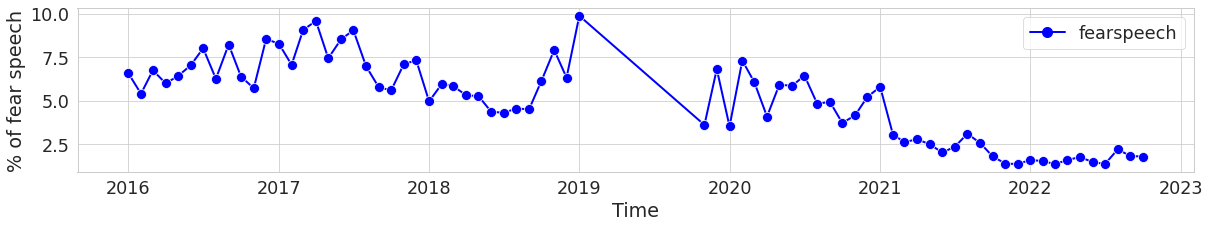

In [35]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 3)

sns.set(context='paper',style='whitegrid',font_scale=2.0, rc={"lines.linewidth": 2.0,"lines.markersize": 10})
sns.lineplot(data = df[["fearspeech"]],palette=['blue'],markers=['o'])
plt.xlabel("Time")
plt.ylabel("% of fear speech")
path='../Results/fearspeech_temporal_facebook.pdf'
plt.savefig(path,bbox_inches='tight',dpi=400)
    

In [36]:
df_final.loc[element['id']].iloc[0]

'Generations'

In [38]:
dataframe=pd.DataFrame({'post': posts,
     'label': labels_all,
     'date': dates_all
    })

In [41]:
dataframe_sub=dataframe.dropna(axis=0)


for index,row in dataframe_sub[dataframe_sub['label']=='fear'].sample(100).iterrows():
    if('jihad' in row['post'].lower() or 'muslim' in row['post'].lower()):
        pass
    else:
        print(row['post'])
        print("Label: ",row['label'])
        print("Date:", row['date'])
        print("-------------------------")
        

New Jersey, did you know that illegal aliens in your state are 440 percent more likely to end up in jail than citizens or lawfully present immigrants?
Label:  fear
Date: 14/1/2020
-------------------------
#Turkey says its released 47,000 migrants into #Europe. That us 47,000 on a #hijrah most are men of military age. https://www.trtworld.com/turkey/number-of-migrants-leaving-turkey-reaches-47-113-minister-34211
Label:  fear
Date: 29/2/2020
-------------------------
Your religious freedom is under attack, yet again, by the UN. Help us stop them. Sign and share. https://protectreligiousfreedoms.org/
Label:  fear
Date: 3/10/2020
-------------------------
As the world struggles to fight against an invisible enemy, another frightening threat is rising: Antisemitism. Throughout history, the Jewish people have been the scapegoat for may of the world's problems, datinng back to the black plague. For those who know history, you know that these lies had deadly consequences that resulted in the 

In [ ]:
1st one annotated dataset in Gab 
2nd one closest in similarity in Twitte

In [ ]:
df_final

In [7]:
datetime.fromisoformat(df_final.loc[0]['Post Created'][:-4])

NameError: name 'df_final' is not defined

In [ ]:
df_final